In [1]:
import torch
from torchvision import transforms, datasets, models
import numpy as np
import cv2
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [2]:
train_data_path = 'data/train'
val_data_path = 'data/validation'

# Define transforms for the training data and testing data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # rescale the image
        transforms.RandomHorizontalFlip(), # randomly flip image horizontally
        transforms.RandomRotation(10), # randomly rotate image
        transforms.ToTensor(), # convert the image to a Tensor
        transforms.Normalize([0.485, 0.456, 0.406], # normalize image for pre-trained model
                                [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256), # rescale the image
        transforms.CenterCrop(224), # crop image
        transforms.ToTensor(), # convert the image to a Tensor
        transforms.Normalize([0.485, 0.456, 0.406], # normalize image for pre-trained model
                                [0.229, 0.224, 0.225])
    ]),
}

train_dataset = datasets.ImageFolder(train_data_path, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_data_path, transform=data_transforms['validation'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 32, shuffle=True)
# Dataloader iterators, make sure to shuffle

print(train_dataset.class_to_idx)
    

{'damage': 0, 'no_damage': 1}


In [3]:


class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

def add_se_module(resnet_model):
    for child_name, child in resnet_model.named_children():
        if isinstance(child, nn.Sequential):
            for block_name, block in child.named_children():
                if block.downsample is not None:
                    block.add_module("se_module", SEModule(block.downsample[0].out_channels))
                else:
                    block.add_module("se_module", SEModule(block.conv2.out_channels))
    return resnet_model

class ResNetWithTransformer(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetWithTransformer, self).__init__()
        
        # Load the pre-trained ResNet101 model with SE blocks
        self.base_model = models.resnet101(pretrained=True)
        self.base_model = add_se_module(self.base_model)
        
        # Remove the final FC layer (since we're adding our own classifier)
        modules = list(self.base_model.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        # Transformer encoder layers
        encoder_layers = TransformerEncoderLayer(d_model=2048, nhead=4)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=2)

        # Final classifier for 2 classes (damaged or not)
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.resnet(x)
        
        # Prepare the features for the transformer
        x = x.view(x.size(0), x.size(1), -1)  # BxCxN
        x = x.permute(2, 0, 1)  # Nx B x C
        
        # Pass through the transformer encoder
        x = self.transformer_encoder(x)
        x = x.permute(1, 2, 0)  # B x C x N
        
        # Global Average Pooling (GAP)
        x = F.adaptive_avg_pool1d(x, 1)
        x = x.view(x.size(0), -1)
        
        x = self.classifier(x)
        
        return x

model = ResNetWithTransformer()

# Freeze the pre-trained model weights
for param in model.base_model.parameters():
    param.requires_grad = False

# If GPU is available, use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

print(model)

c:\Users\zhuoq\anaconda3\envs\tensorflow2.6.0\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zhuoq\anaconda3\envs\tensorflow2.6.0\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetWithTransformer(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [4]:
for name, module in model.named_modules():
    print(name)



base_model
base_model.conv1
base_model.bn1
base_model.relu
base_model.maxpool
base_model.layer1
base_model.layer1.0
base_model.layer1.0.conv1
base_model.layer1.0.bn1
base_model.layer1.0.conv2
base_model.layer1.0.bn2
base_model.layer1.0.conv3
base_model.layer1.0.bn3
base_model.layer1.0.relu
base_model.layer1.0.downsample
base_model.layer1.0.downsample.0
base_model.layer1.0.downsample.1
base_model.layer1.0.se_module
base_model.layer1.0.se_module.avg_pool
base_model.layer1.0.se_module.fc
base_model.layer1.0.se_module.fc.0
base_model.layer1.0.se_module.fc.1
base_model.layer1.0.se_module.fc.2
base_model.layer1.0.se_module.fc.3
base_model.layer1.1
base_model.layer1.1.conv1
base_model.layer1.1.bn1
base_model.layer1.1.conv2
base_model.layer1.1.bn2
base_model.layer1.1.conv3
base_model.layer1.1.bn3
base_model.layer1.1.relu
base_model.layer1.1.se_module
base_model.layer1.1.se_module.avg_pool
base_model.layer1.1.se_module.fc
base_model.layer1.1.se_module.fc.0
base_model.layer1.1.se_module.fc.1
ba

In [5]:
# Train the model
epochs = 200
max_accuracy = 0.0
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    accuracy = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass
        loss.backward()
        # Perform optimization
        optimizer.step()
        # Update train loss
        train_loss += loss.item()*data.size(0)
    # Calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    # Print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))
    # Validation
    model.eval()
    for batch_idx, (data, target) in enumerate(val_loader):
        # Move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # Forward pass
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss 
        val_loss += loss.item()*data.size(0)
        # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy += torch.mean(correct_tensor.type(torch.FloatTensor))
    # Calculate average losses
    val_loss = val_loss/len(val_loader.dataset)
    accuracy = accuracy/len(val_loader)
    # Print training/validation statistics 
    print('Epoch: {} \tValidation Loss: {:.6f} \tAccuracy: {:.2f}%'.format(
        epoch+1, 
        val_loss,
        accuracy*100
        ))
    #保存所有epoch中正确率最高的模型
    
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        torch.save(model.state_dict(), 'model.pt')
        print('Model saved!')
        

Epoch: 1 	Training Loss: 0.313740
Epoch: 1 	Validation Loss: 0.175550 	Accuracy: 92.46%
Model saved!
Epoch: 2 	Training Loss: 0.253658
Epoch: 2 	Validation Loss: 0.164142 	Accuracy: 92.81%
Model saved!
Epoch: 3 	Training Loss: 0.225032
Epoch: 3 	Validation Loss: 0.172588 	Accuracy: 92.36%
Epoch: 4 	Training Loss: 0.215724
Epoch: 4 	Validation Loss: 0.156157 	Accuracy: 93.95%
Model saved!
Epoch: 5 	Training Loss: 0.217741
Epoch: 5 	Validation Loss: 0.125821 	Accuracy: 94.79%
Model saved!
Epoch: 6 	Training Loss: 0.205119
Epoch: 6 	Validation Loss: 0.121966 	Accuracy: 94.99%
Model saved!
Epoch: 7 	Training Loss: 0.199718
Epoch: 7 	Validation Loss: 0.157153 	Accuracy: 93.50%
Epoch: 8 	Training Loss: 0.208045
Epoch: 8 	Validation Loss: 0.113916 	Accuracy: 95.63%
Model saved!
Epoch: 9 	Training Loss: 0.198005
Epoch: 9 	Validation Loss: 0.123139 	Accuracy: 95.44%
Epoch: 10 	Training Loss: 0.185913
Epoch: 10 	Validation Loss: 0.118294 	Accuracy: 95.29%
Epoch: 11 	Training Loss: 0.192726
Epoch

In [4]:
# Test the model
test_data_path = 'data/test'
test_dataset = datasets.ImageFolder(test_data_path, transform=data_transforms['validation'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True)
model.load_state_dict(torch.load('model.pt'))
model.eval()
accuracy = 0.0
error_count = 0
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    _, pred = torch.max(output, dim=1)
    for i in range(len(target)):
        print(test_loader.dataset.imgs[i][0].split('/')[-1],
              "Pre Res:","damage" if pred[i] == 1 else "no_damage", 
              "Actul Res:","damage" if target[i] == 1 else "no_damage")
        if pred[i] != target[i]:
            error_count += 1
            print("Error Prediction")
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    accuracy += torch.mean(correct_tensor.type(torch.FloatTensor))
accuracy = accuracy/len(test_loader)
error_rate = error_count/len(test_loader.dataset)
print('Test Accuracy: {:.2f}%'.format(accuracy*100), "Error Rate: {:.2f}%".format(error_rate*100))


test\damage\-93.548123_30.900623.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.560128_30.894917.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.578271_30.779923999999998.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.590598_30.694956.jpeg Pre Res: damage Actul Res: damage
test\damage\-93.604017_30.793719.jpeg Pre Res: damage Actul Res: damage
test\damage\-93.6141_30.754263.jpeg Pre Res: damage Actul Res: damage
test\damage\-93.618483_30.730039.jpeg Pre Res: damage Actul Res: damage
test\damage\-93.65613_30.076164000000002.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.658785_30.206929.jpeg Pre Res: damage Actul Res: damage
test\damage\-93.659161_30.202384999999996.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.65936500000001_30.138793.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.659805_30.138094.jpeg Pre Res: damage Actul Res: damage
test\damage\-93.660431_30.20485.jpeg Pre Res: no_damage Actul Res: n

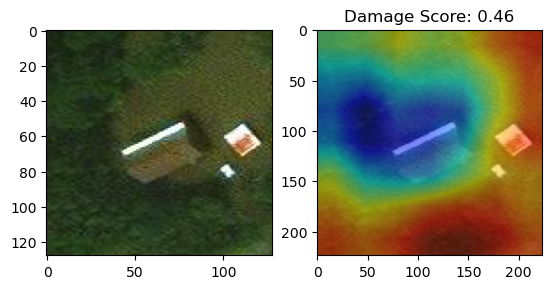

In [5]:
#define Grad-CAM
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.target_layer = dict([*self.model.named_modules()])[layer_name]
        self.gradients = None
        self.target_value = None  # Added
        self.target_layer.register_forward_hook(self.save_gradient)
        self.target_layer.register_forward_hook(self.save_value)  # Added

    def save_gradient(self, module, input, output):
        self.gradients = output

    def save_value(self, module, input, output):  # Added
        self.target_value = output

    def __call__(self, inputs, index=None):
        outputs = self.model(inputs)
        if index is None:
            index = torch.argmax(outputs, 1)
        one_hot = torch.zeros((1, outputs.size()[-1]), dtype=torch.float32)
        one_hot[0][index] = 1
        one_hot = one_hot.requires_grad_().to(device)
        one_hot = torch.sum(one_hot * outputs)
        one_hot.backward(retain_graph=True)
        grad_values = self.gradients[0].cpu().data.numpy()
        target = self.target_value[0].cpu().data.numpy()  # Modified
        weights = np.mean(grad_values, axis=(1, 2))
        cam = np.zeros(target.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam
class DamgeScore:
    def __init__(self, model,layer_name):
        self.grad_cam = GradCAM(model, layer_name)
    def score(self, image_tensor):
        cam = self.grad_cam(image_tensor)
        damge_score = np.mean(cam)
        return damge_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetWithTransformer()
model.to(device)
damge_score = DamgeScore(model, 'base_model.layer4')  # layer4.2.se_module is the last layer of ResNet101
grad_cam = GradCAM(model, 'base_model.layer4')  # layer4.2.se_module is the last layer of ResNet101

# 4. visualize
def visualize(image_path, cam):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # resize the image to (224,224,3)
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

'''
# visualize all test images and save in outputs folder
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    _, pred = torch.max(output, dim=1)
    for i in range(len(target)):
        img_path = test_loader.dataset.imgs[i][0]
        print(img_path)
        cam = grad_cam(data[i].unsqueeze(0), target[i])
        cam = cv2.resize(cam, (224, 224))
        cam = visualize(img_path, cam)
        score = damge_score.score(data[i].unsqueeze(0))
        plt.figure()
        plt.subplot(121)
        plt.imshow(plt.imread(img_path))
        plt.subplot(122)
        plt.imshow(cam)
        plt.title("Damage Score: {:.2f}".format(score))
        plt.show()
        #保存图片到本地outputs文件夹
        plt.imsave('outputs\\' + img_path.split('\\')[-1], cam)
'''
#visualize one image
score = []
for img, label in test_loader:
    if label[0] == 0:
        img = img.requires_grad_().to(device)  # Move img to the appropriate device
        cam = grad_cam(img)
        score = damge_score.score(img)
        vis = visualize(test_dataset.imgs[0][0], cam)
        plt.figure()
        plt.subplot(121)
        plt.imshow(plt.imread(test_dataset.imgs[0][0]))
        plt.subplot(122)
        plt.imshow(vis)
        plt.title("Damage Score: {:.2f}".format(score))
        plt.show()
        break




